In [172]:
import numpy as np
import pandas as pd
import lxml.etree as etree
import sqlite3 as sql
from process import *
import re
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [405]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, precision_score
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [3]:
data = pd.read_csv('../data/prem_data_elo.csv', index_col = 'Unnamed: 0')
data.head()

match_api_id  league_id                 date  home_team_api_id  \
0        489044       1729  2008-08-16 00:00:00              8472   
1        489045       1729  2008-08-16 00:00:00              8654   
2        489047       1729  2008-08-16 00:00:00              8668   
3        489048       1729  2008-08-16 00:00:00              8549   
4        489049       1729  2008-08-16 00:00:00              8559   

     home_team_name  away_team_api_id     away_team_name  home_team_goal  \
0        Sunderland              8650          Liverpool               0   
1   West Ham United              8528     Wigan Athletic               2   
2           Everton              8655   Blackburn Rovers               2   
3     Middlesbrough              8586  Tottenham Hotspur               2   
4  Bolton Wanderers             10194         Stoke City               3   

   away_team_goal  home_team_foul_reason_from_behind  ...  \
0               2                                2.0  ...   
1               4                                0.0  ...   
2              12                                2.0  ...   
3               4                                0.0  ...   
4               4                                2.0  ...   

   away_team_card_reason_pushing  home_team_card_reason_diving  \
0                            0.0                           0.0   
1                            0.0                           0.0   
2                            0.0                           0.0   
3                            0.0                           0.0   
4                            0.0                           0.0   

   away_team_card_reason_diving  home_team_card_reason_hands  \
0                           0.0                          0.0   
1                           0.0                          0.0   
2                           0.0                          0.0   
3                           0.0                          0.0   
4                           0.0                          0.0   

   away_team_card_reason_hands  home_team_card_reason_Removing Shirt  \
0                          0.0                                   0.0   
1                          0.0                                   0.0   
2                          0.0                                   0.0   
3                          0.0                                   0.0   
4                          0.0                                   0.0   

   away_team_card_reason_Removing Shirt  result  home_elo  away_elo  
0                                   0.0       L    1600.0    1600.0  
1                                   0.0       L    1600.0    1600.0  
2                                   0.0       L    1600.0    1600.0  
3                                   0.0       L    1600.0    1600.0  
4                                   0.0       L    1600.0    1600.0  

[5 rows x 70 columns]

In [136]:
X = data[data.columns[9:]].drop(
    ['result', 'home_elo', 'away_elo'],
axis = 1)
y = data['result']

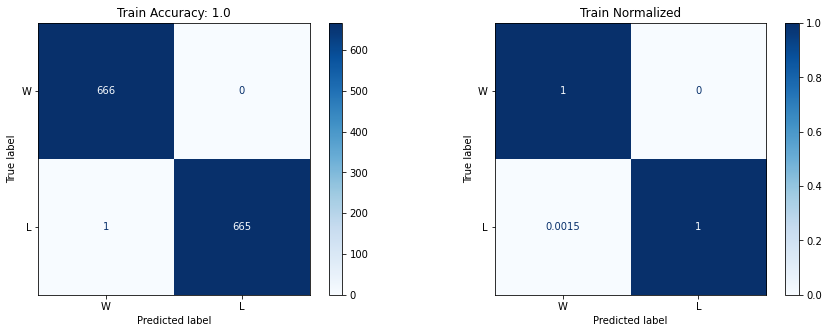

   Class  Accuracy  Precision    Recall        F1  Support
0      W  1.000000   0.998501  1.000000  0.999250      666
1      L  0.998498   1.000000  0.998498  0.999249      666
2  Total  0.999249   0.999250  0.999249  0.999249     1332


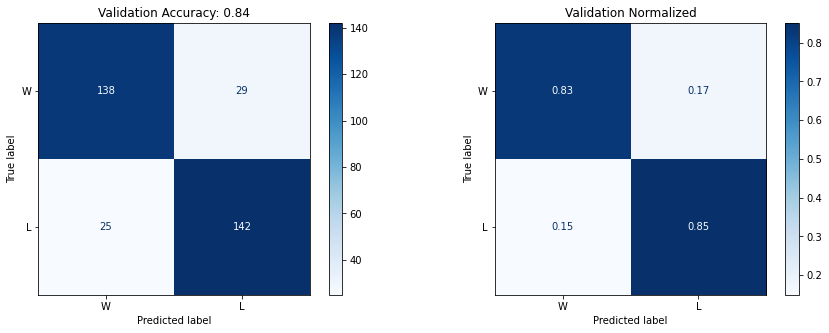

   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.826347   0.846626  0.826347  0.836364      167
1      L  0.850299   0.830409  0.850299  0.840237      167
2  Total  0.838323   0.838518  0.838323  0.838300      334


In [7]:
X_ds, y_ds, weights = transform_target(X, y, class_labels = ['W', 'L'], weight = True, down_sample = True)
X_train, X_test, y_train, y_test = train_test_split(X_ds, y_ds, test_size = 0.2, stratify = y_ds)

clf = RFpipe(weights = weights).fit(X_train, y_train)
print(metric_suite(clf, X_train, y_train, labels = ['W', 'L'], type_ = 'Train', cm = True, save = 'train_cm.png'))
print(metric_suite(clf, X_test, y_test, labels = ['W', 'L'], type_ = 'Validation', cm = True, save = 'valid_cm.png'))

In [893]:
pred_proba = clf['rf'].predict_proba(X_test.values)
# Pred probability for class 0
pred_proba_0 = np.apply_along_axis(np.max, 1,pred_proba[np.apply_along_axis(np.argmax, 1, pred_proba) == 0])
pred_proba_1 = np.apply_along_axis(np.max, 1,pred_proba[np.apply_along_axis(np.argmax, 1, pred_proba) == 1])


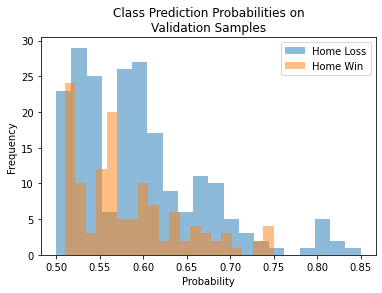

In [896]:
#plt.hist(clf['rf'].predict_proba(X_test.values)[:, 0], alpha = 0.5, bins = 20)
#plt.hist(clf['rf'].predict_proba(X_test.values)[:, 1], alpha = 0.5, bins = 20)
plt.hist(pred_proba_0, alpha = 0.5, bins = 20)
plt.hist(pred_proba_1, alpha = 0.5, bins = 20)
plt.legend(labels = ['Home Loss', 'Home Win'])
plt.title('Class Prediction Probabilities on\nValidation Samples')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.savefig('rf_class_probs.png', dpi = 200)
plt.show()

In [907]:
from sklearn.metrics import roc_curve, RocCurveDisplay

In [911]:
fpr, tpr, thresholds = roc_curve([0 if x == 'L' else 1 for x in y_test], [0 if x == 'L' else 1 for x in clf.predict(X_test)], pos_label = 1)

In [910]:
thresholds.shape

(3,)

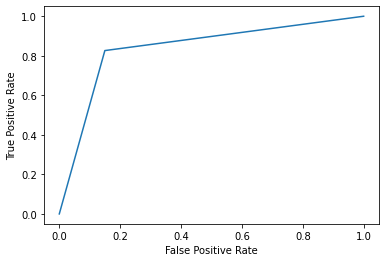

In [913]:
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.show()

In [141]:
r = permutation_importance(clf, X_test, y_test, n_repeats = 30)

qual_idx = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] > 0:
        qual_idx += [i]
        print("{feat}\t\t{mean} +/- {std}".format(
            feat = X.columns[i],
            mean = np.round(r.importances_mean[i], 3),
            std = np.round(r.importances_std[i], 3)
        ))

home_team_card_color_y		0.092 +/- 0.018
home_team_foul_reason_penalty		0.024 +/- 0.007
away_team_card_reason_stall_time		0.017 +/- 0.005
home_team_foul_reason_pull		0.016 +/- 0.006
away_team_card_reason_pushing		0.009 +/- 0.002


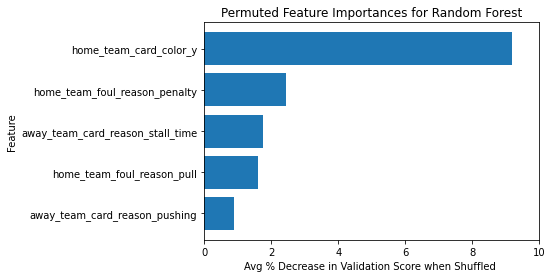

In [151]:
plt.barh(X.columns[qual_idx][::-1], r.importances_mean[qual_idx][::-1]*100)
plt.title('Permuted Feature Importances for Random Forest')
plt.xlabel('Avg % Decrease in Validation Score when Shuffled ')
plt.ylabel('Feature')
plt.xticks(range(0, 11, 2))
plt.savefig('feat_imp_rf.png', dpi = 200, bbox_inches='tight')
plt.show()

In [94]:
print("Min depth", np.min([x.tree_.max_depth for x in clf['rf'].estimators_]))
np.argmin([x.tree_.max_depth for x in clf['rf'].estimators_])

Min depth 27


52

In [115]:
path = clf['rf'].estimators_[52].cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [138]:
X_ds, y_ds, weights = transform_target(X, y, class_labels = ['W', 'L'], weight = True, down_sample = True)
X_ds = StandardScaler().fit_transform(X_ds)
y_ds_mod = np.array([0 if i == 'L' else 1 for i in y])

In [139]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(clf['rf'].estimators_[52], X_ds, y_ds_mod,
                target_name="result",
                feature_names= X.columns,
                class_names= list(clf.classes_))

viz.save("decision_tree.svg")

In [131]:
from sklearn import tree

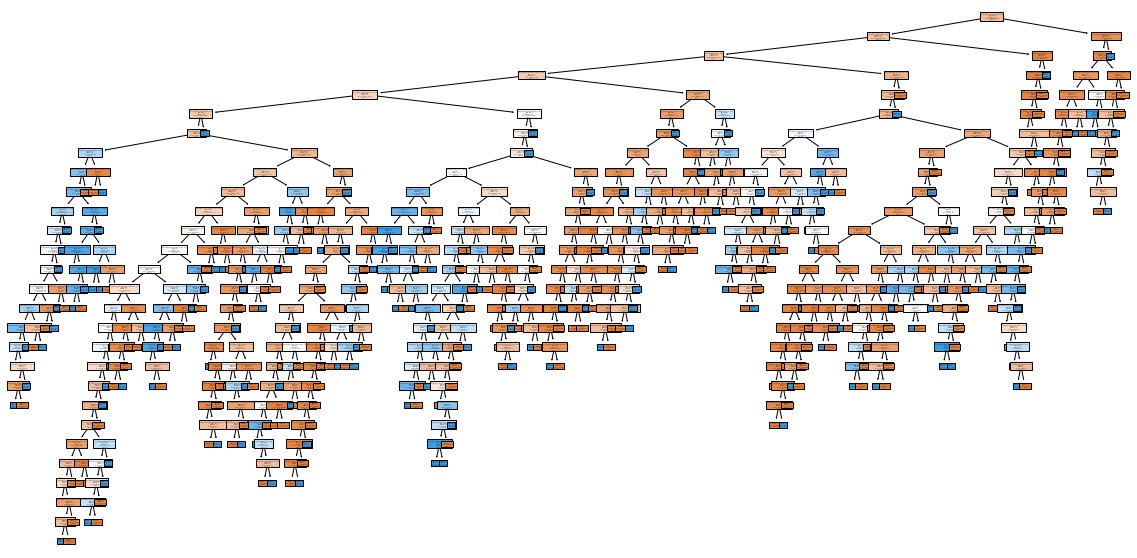

In [135]:
fig, axs = plt.subplots(figsize = (20,10))
tree.plot_tree(clf['rf'].estimators_[52], feature_names = X.columns, class_names = list(clf.classes_), filled = True)
plt.savefig('sklearn_tree.png', dpi = 1000)
plt.show()

In [180]:
r = re.compile(".*card_color")
cc_columns = list(filter(r.match, list(X.columns)))

In [181]:
import itertools
combos = [list(subset) for subset in itertools.combinations(cc_columns, 2)]
len(combos)

15

In [187]:
cor_matrix = X.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

In [218]:
a, b = np.where(upper_tri > 0.6)
for w, z in zip(cor_matrix.columns[a], cor_matrix.columns[b]):
    print(w, ' & ', z, np.round(cor_matrix[w][z], 3))

home_team_foul_reason_pushing  &  away_team_foul_reason_pushing 0.611
home_team_foul_reason_serious_foul  &  home_team_card_reason_serious_fouls 0.649
away_team_foul_reason_serious_foul  &  away_team_card_reason_serious_fouls 0.654
home_team_foul_reason_trip  &  away_team_foul_reason_trip 0.772
away_team_foul_reason_diving  &  away_team_card_reason_diving 0.616


In [274]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.5)]
to_drop

['away_team_foul_reason_from_behind',
 'away_team_foul_reason_pushing',
 'away_team_foul_reason_trip',
 'home_team_card_reason_serious_fouls',
 'away_team_card_reason_serious_fouls',
 'home_team_card_reason_diving',
 'away_team_card_reason_diving']

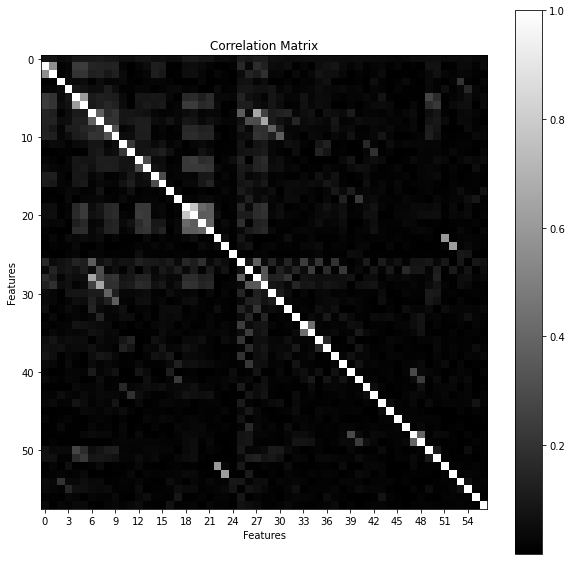

In [303]:
down_cor = cor_matrix.drop('home_team_foul_reason_goalkeeper_hands',axis=1).drop('home_team_foul_reason_goalkeeper_hands',axis=0)
fig, axs= plt.subplots(figsize = (10,10))
plt.imshow(np.row_stack([down_cor.apply(np.mean, axis = 0), down_cor.values]), cmap = 'gray')
plt.colorbar()
plt.xticks(range(0,57,3))
plt.xlabel('Features')
plt.ylabel('Features')
plt.title('Correlation Matrix')
plt.savefig('cor_mat.png', dpi = 200, bbox_inches = 'tight')
plt.show()

In [714]:
X_ds

array([[-0.50114457, -0.54856895, -0.57866235, ..., -0.15070939,
        -0.11568057, -0.06495698],
       [ 7.65224271,  2.1367862 , -0.57866235, ..., -0.15070939,
        -0.11568057, -0.06495698],
       [-0.50114457,  1.68922701, -0.57866235, ..., -0.15070939,
        -0.11568057, -0.06495698],
       ...,
       [-0.50114457, -0.54856895, -0.57866235, ..., -0.15070939,
        -0.11568057, -0.06495698],
       [-0.50114457, -0.54856895,  1.07778349, ..., -0.15070939,
        -0.11568057, -0.06495698],
       [-0.50114457, -0.54856895,  1.07778349, ..., -0.15070939,
        -0.11568057, -0.06495698]])

  0%|          | 0/15 [00:00<?, ?it/s]

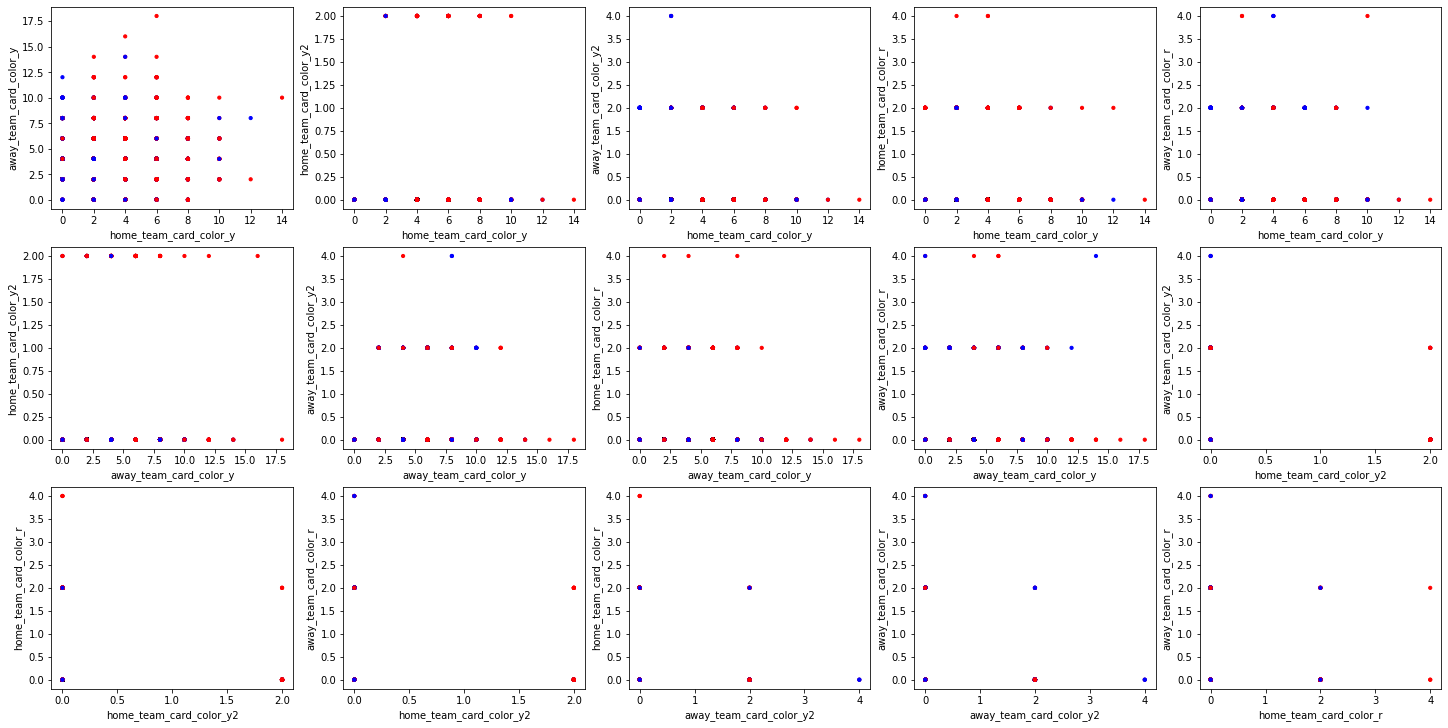

In [716]:
fig, axs = plt.subplots(3, 5, figsize = (20,10), constrained_layout = True)
for i, ax in enumerate(tqdm(axs.flat)):
    a, b = combos[i]
    ax.scatter(X[a], X[b], c = ['r' if x == 'L' else 'b' for x in y], s = 10)
    ax.set_xlabel(a)
    ax.set_ylabel(b)
plt.show()

In [312]:
clf_logit = train_test(Logitpipe, X.drop(to_drop, axis = 1), y, weight = True, down_sample = True, class_labels = ['W', 'L'], return_clf = True)

>>>Preprocess done {'W': 1.0, 'L': 2.061224489795918}
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.400901   0.782991  0.400901  0.530288      666
1      L  0.888889   0.597376  0.888889  0.714544      666
2  Total  0.644895   0.690184  0.644895  0.622416     1332
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.449102   0.742574  0.449102  0.559701      167
1      L  0.844311   0.605150  0.844311  0.705000      167
2  Total  0.646707   0.673862  0.646707  0.632351      334


In [316]:
clf_drop = train_test(RFpipe, X.drop(to_drop, axis = 1), y, weight = True, down_sample = True, class_labels = ['W', 'L'], return_clf = True)

>>>Preprocess done {'W': 1.0, 'L': 2.061224489795918}
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.990991   1.000000  0.990991  0.995475      666
1      L  1.000000   0.991071  1.000000  0.995516      666
2  Total  0.995495   0.995536  0.995495  0.995495     1332
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.790419   0.835443  0.790419  0.812308      167
1      L  0.844311   0.801136  0.844311  0.822157      167
2  Total  0.817365   0.818290  0.817365  0.817233      334


In [296]:
r = permutation_importance(clf_drop, X_test.drop(to_drop, axis=1), y_test, n_repeats = 30)

qual_idx = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] > 0:
        qual_idx += [i]
        print("{feat}\t\t{mean} +/- {std}".format(
            feat = X.drop(to_drop, axis = 1).columns[i],
            mean = np.round(r.importances_mean[i], 3),
            std = np.round(r.importances_std[i], 3)
        ))

home_team_card_color_y		0.072 +/- 0.017
home_team_foul_reason_penalty		0.034 +/- 0.007
home_team_foul_reason_serious_foul		0.022 +/- 0.007
away_team_foul_reason_pull		0.02 +/- 0.009
away_team_card_reason_stall_time		0.019 +/- 0.006
away_team_card_color_r		0.018 +/- 0.007
home_team_foul_reason_shirt_pull		0.018 +/- 0.006
away_team_foul_reason_shirt_pull		0.017 +/- 0.004
away_team_card_color_y2		0.007 +/- 0.003
home_team_card_reason_stall_time		0.006 +/- 0.002


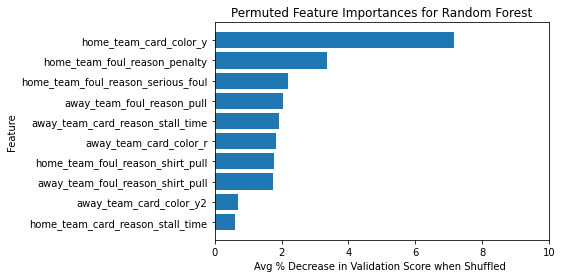

In [317]:
plt.barh(X.drop(to_drop, axis = 1).columns[qual_idx][::-1], r.importances_mean[qual_idx][::-1]*100)
plt.title('Permuted Feature Importances for Random Forest')
plt.xlabel('Avg % Decrease in Validation Score when Shuffled ')
plt.ylabel('Feature')
plt.xticks(range(0, 11, 2))
#plt.savefig('feat_imp_rf.png', dpi = 200, bbox_inches='tight')
plt.show()

In [831]:
X_drop = X.drop(to_drop + ['home_team_foul_reason_goalkeeper_hands', 'away_team_foul_reason_goalkeeper_hands'], axis = 1)

In [339]:
from sklearn.metrics.pairwise import manhattan_distances
from scipy.stats import iqr

In [338]:
mean = X_drop.mean(axis = 0).values
std = X_drop.std(axis = 0)
manhattan_distances(X_drop, mean.reshape(1, -1)).reshape(-1)

array([18.22102332, 21.86355726, 23.85798817, ..., 20.69787678,
       32.2540898 , 22.84893839])

In [847]:
labels.shape

(49,)

  0%|          | 0/25 [00:00<?, ?it/s]

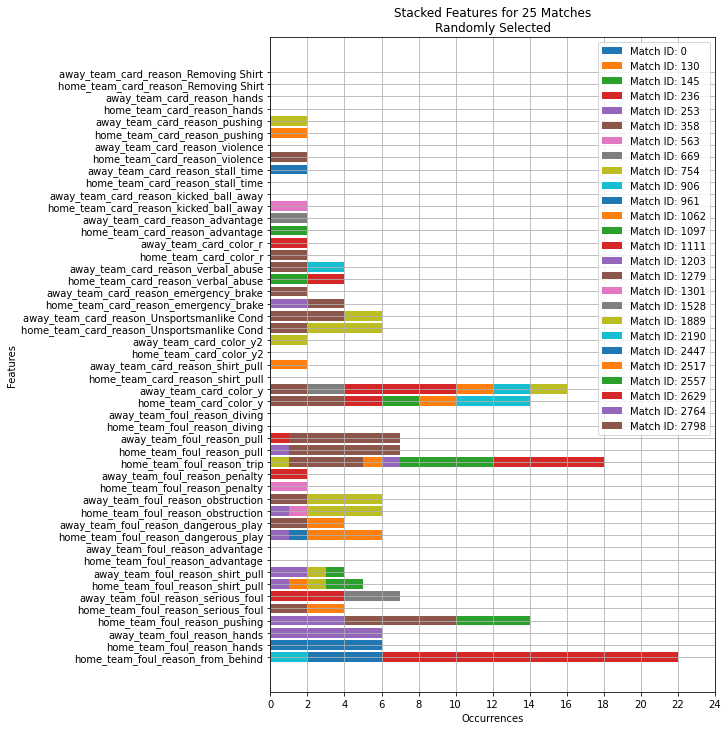

In [845]:
labels = X_drop.columns
vals = X_drop[labels].values
vals = vals[vals.sum(axis = 1) != 0]
fig, axs = plt.subplots(figsize = (10,10), constrained_layout = True)
np.random.seed(1)
axs.barh(labels, vals[0], label = "Match ID: 0")
idx = sorted(np.random.choice(np.arange(1,vals.shape[0]), size = 25))
#idx = range(vals.shape[0])
for i,id_ in enumerate(tqdm(idx)):
    axs.barh(labels, vals[id_], left = list(vals[idx[i-1]]), label = "Match ID: {id}".format(id = id_))
plt.legend()
plt.xticks(range(0, 26,2))
plt.grid()
plt.title('Stacked Features for 25 Matches\nRandomly Selected')
plt.xlabel('Occurrences')
plt.ylabel('Features')
plt.savefig('stacked_bar_feat.png', dpi = 400, bbox_inches = 'tight')
plt.show()

  0%|          | 0/49 [00:00<?, ?it/s]

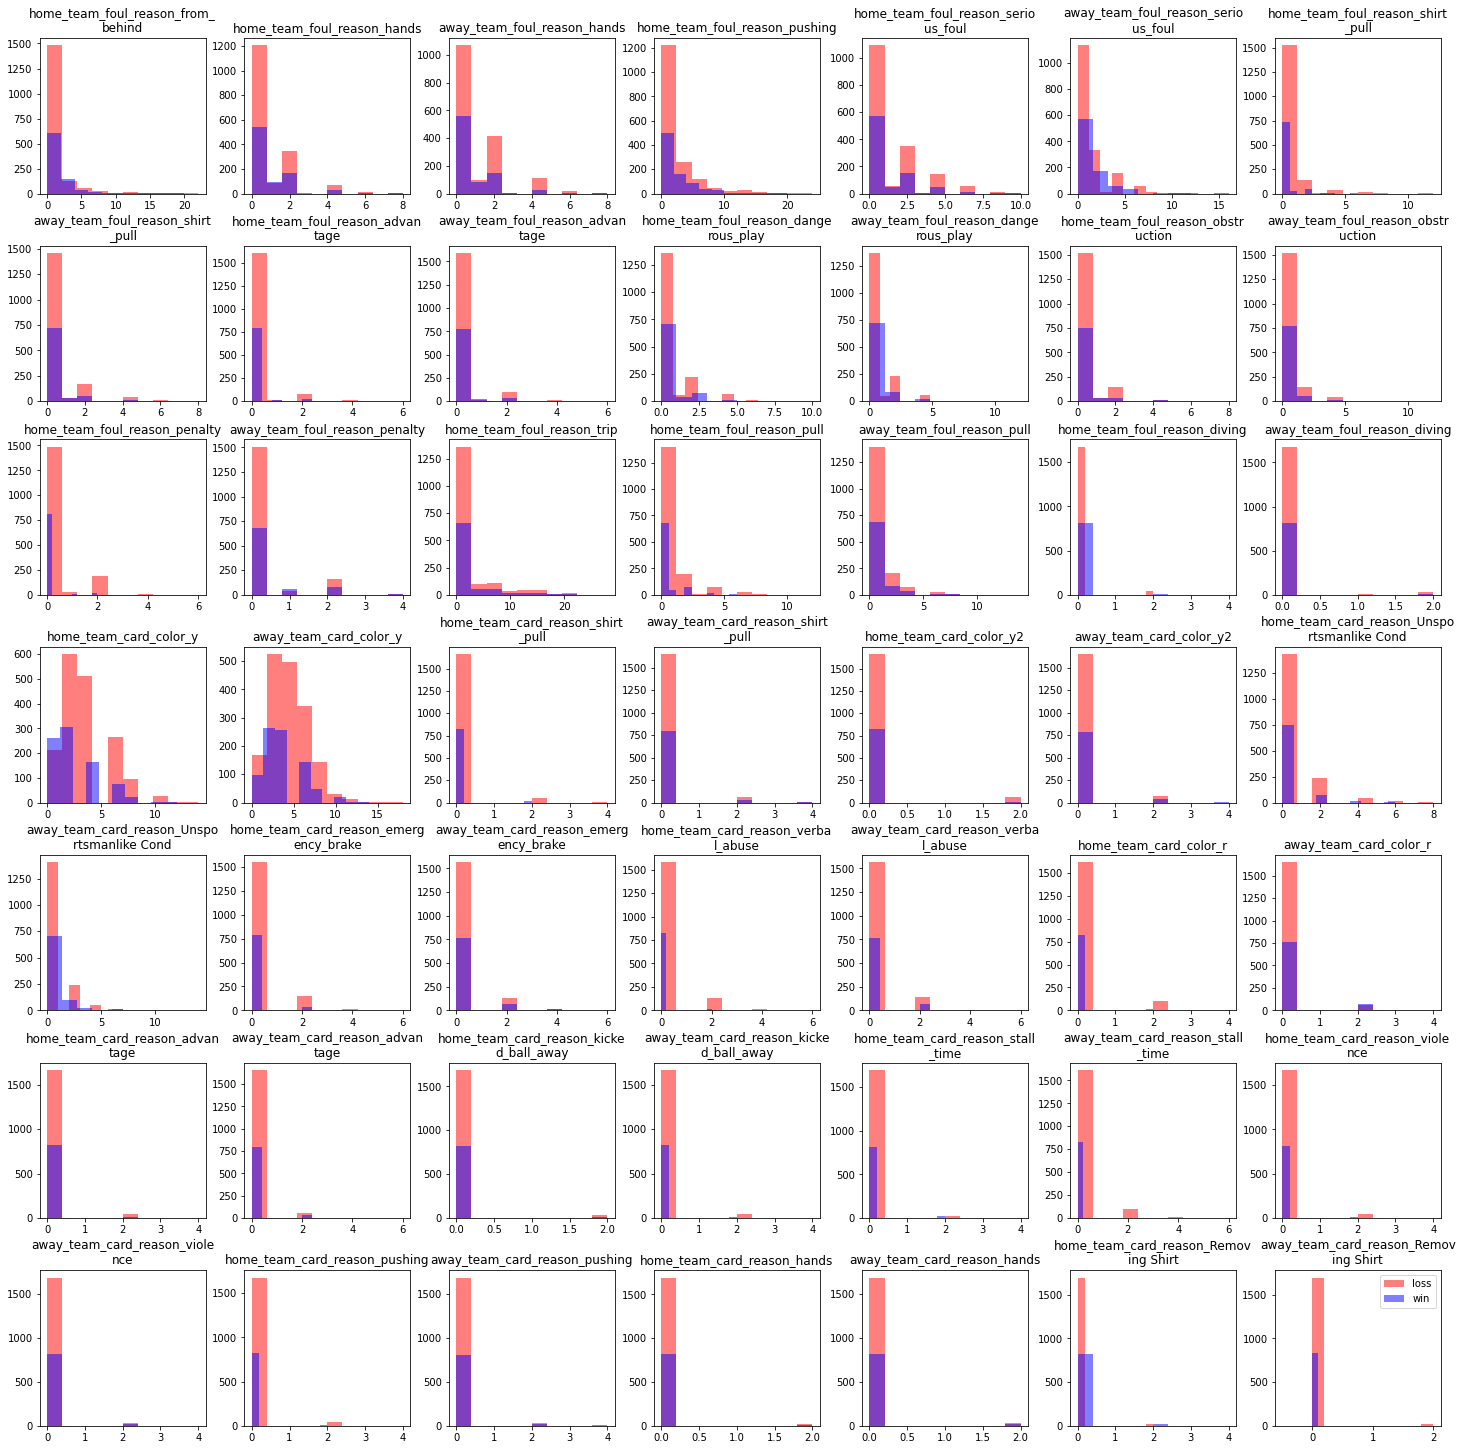

In [846]:
fig, axs = plt.subplots(7, 7, figsize= (20,20), constrained_layout = True)
for i, ax in enumerate(tqdm(axs.flat)):
    ax.hist(X_drop[X_drop.columns[i]][y == 'L'],alpha = 0.5, color = 'r')
    ax.hist(X_drop[X_drop.columns[i]][y == 'W'],alpha = 0.5, color = 'b')
    ax.set_title(X_drop.columns[i] if len(X_drop.columns[i]) < 30 else X_drop.columns[i][:27] + '\n' + X_drop.columns[i][27:])
plt.legend(labels = ['loss', 'win'])
plt.savefig('singlevar_eda.png', dpi = 400, bbox_inches = 'tight')
plt.show()

In [387]:
home_fouls = X_drop[y != 'D'].filter(regex = 'home_team_foul').sum(axis = 1)
away_fouls = X_drop[y != 'D'].filter(regex = 'away_team_foul').sum(axis = 1)
home_cards = X_drop[y != 'D'].filter(regex = 'home_team_card_reason').sum(axis = 1)
away_cards = X_drop[y != 'D'].filter(regex = 'away_team_card_reason').sum(axis = 1)

In [378]:
print("HFouls >= Afouls & W: ", np.round(np.mean((home_fouls >= away_fouls) & (data[y != 'D']['result'] == 'W'))*100, 1), '%')
print("HFouls >= Afouls & L: ", np.round(np.mean((home_fouls >= away_fouls) & (data[y != 'D']['result'] == 'L'))*100, 1), '%')
print("HFouls < Afouls & W: ", np.round(np.mean((home_fouls < away_fouls) & (data[y != 'D']['result'] == 'W'))*100, 1), '%')
print("HFouls < Afouls & L: ", np.round(np.mean((home_fouls < away_fouls) & (data[y != 'D']['result'] == 'L'))*100, 1), '%')

HFouls >= Afouls & W:  24.2 %
HFouls >= Afouls & L:  55.5 %
HFouls < Afouls & W:  8.4 %
HFouls < Afouls & L:  11.9 %


In [389]:
print("HCards >= ACards & W: ", np.round(np.mean((home_cards >= away_cards) & (data[y != 'D']['result'] == 'W'))*100, 1), '%')
print("HCards >= ACards & L: ", np.round(np.mean((home_cards >= away_cards) & (data[y != 'D']['result'] == 'L'))*100, 1), '%')
print("HCards < ACards & W: ", np.round(np.mean((home_cards < away_cards) & (data[y != 'D']['result'] == 'W'))*100, 1), '%')
print("HCards < ACards & L: ", np.round(np.mean((home_cards < away_cards) & (data[y != 'D']['result'] == 'L'))*100, 1), '%')

HCards >= ACards & W:  22.6 %
HCards >= ACards & L:  46.8 %
HCards < ACards & W:  10.0 %
HCards < ACards & L:  20.5 %


In [394]:
print('Home Wins', np.round(np.mean(data[y != 'D']['result'] == 'W')*100, 1), '%')
print('Home Losses', np.round(np.mean(data[y != 'D']['result'] == 'L')*100, 1), '%')

Home Wins 32.7 %
Home Losses 67.3 %


In [664]:
#leaves
def leaf_pct(estim, threshold):
    return np.sum(sorted(np.round(np.unique(clf['rf'].estimators_[estim].apply(X_test), return_counts = True)[1]/X_test.shape[0]*100,2))[::-1][:threshold])


In [853]:
pct = [leaf_pct(x, 3) for x in range(len(clf['rf'].estimators_))]

In [692]:
class LeanClassifier:
    
    def __init__(self, base_clf, pct, scale = True, threshold = 50):
        self.base_clf = base_clf
        self.pct = pct
        self.scale = scale
        self.threshold = threshold
        
        self.good_estim = np.where(np.array(pct) > threshold)[0]
        if self.good_estim.shape[0] == 0:
            self.good_estim = [np.argmax(pct)]
        
        self.tree = np.array(self.base_clf['rf'].estimators_)[self.good_estim]
        
    def predict(self, X):
        X_ = X
        if self.scale:
            X_ = self.base_clf['scaler'].transform(X)
        
        class_probs = np.row_stack([
            np.apply_along_axis(lambda x: x[0] - x[1], -1, x.predict_proba(X_)) for x in self.tree
        ]).mean(axis=0)
        
        pred = np.zeros(class_probs.shape[0], dtype = object)
        pred[np.where(class_probs < 0)] = 'W'
        pred[np.where(class_probs >= 0)] = 'L'
    
        return pred
    
    def score(self, X, y):
        return np.mean(self.predict(X) == y)

In [683]:
tune = [LeanClassifier(X_test, y_test, threshold = x) for x in tqdm(range(100))]

  0%|          | 0/100 [00:00<?, ?it/s]

In [693]:
lean_clf = LeanClassifier(clf, pct, threshold = np.argmax(tune))

In [858]:
np.argmax(tune)

29

In [694]:
clf.score(X_train, y_train), lean_clf.score(X_train, y_train)

(0.9992492492492493, 0.9984984984984985)

In [695]:
clf.score(X_test, y_test), lean_clf.score(X_train, y_train)

(0.8383233532934131, 0.9984984984984985)

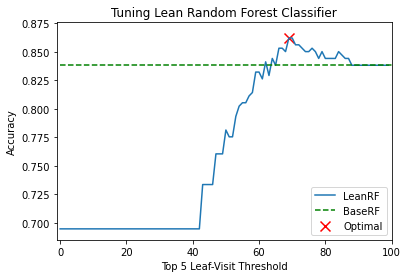

In [914]:
plt.plot(tune[::-1])
plt.plot([0, 100],[0.838323, 0.838323], 'g--')
plt.scatter(np.argmax(tune[::-1]), np.max(tune), marker = 'x', color = 'r', s = 100)
plt.title('Tuning Lean Random Forest Classifier')
plt.xlabel('Top 5 Leaf-Visit Threshold')
plt.ylabel('Accuracy')
plt.legend(labels = ['LeanRF', 'BaseRF', 'Optimal'])
plt.ylim([0.685, 0.876])
plt.xlim([-1,100])
plt.savefig('lean_rf_tune.png', dpi = 200)
plt.show()

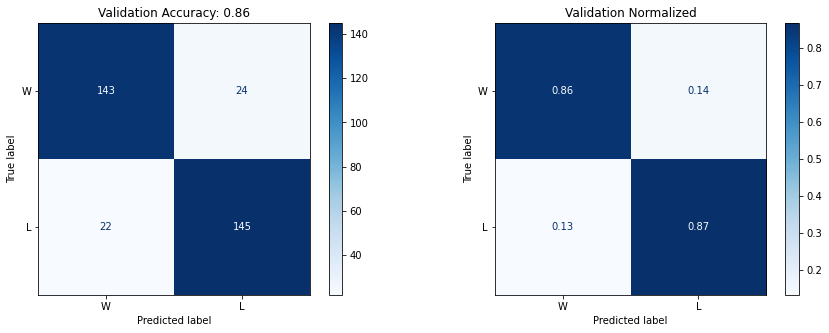

In [687]:
CM(LeanClassifier(X_test, threshold = np.argmax(tune)), y_test, type_ = 'Validation', labels = ['W', 'L'])#, save = 'lean_valid_cm.png')

In [860]:
X.astype(int).head()

home_team_foul_reason_from_behind  away_team_foul_reason_from_behind  \
0                                  2                                  1   
1                                  0                                  4   
2                                  2                                  2   
3                                  0                                  0   
4                                  2                                  6   

   home_team_foul_reason_hands  away_team_foul_reason_hands  \
0                            0                            0   
1                            0                            2   
2                            0                            4   
3                            0                            4   
4                            2                            2   

   home_team_foul_reason_pushing  away_team_foul_reason_pushing  \
0                              1                              1   
1                              2                              0   
2                              0                              2   
3                              0                              2   
4                              8                              2   

   home_team_foul_reason_serious_foul  away_team_foul_reason_serious_foul  \
0                                   0                                   1   
1                                   2                                   0   
2                                   0                                   0   
3                                   2                                   4   
4                                   2                                   4   

   home_team_foul_reason_shirt_pull  away_team_foul_reason_shirt_pull  ...  \
0                                 0                                 1  ...   
1                                 4                                 0  ...   
2                                 6                                 0  ...   
3                                 2                                 2  ...   
4                                 0                                 2  ...   

   home_team_card_reason_violence  away_team_card_reason_violence  \
0                               0                               0   
1                               0                               0   
2                               0                               0   
3                               0                               0   
4                               0                               0   

   home_team_card_reason_pushing  away_team_card_reason_pushing  \
0                              0                              0   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   home_team_card_reason_diving  away_team_card_reason_diving  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   home_team_card_reason_hands  away_team_card_reason_hands  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   home_team_card_reason_Removing Shirt  away_team_card_reason_Removing Shirt  
0                                     0                                     0  
1                                     0                                     0  
2         

In [848]:
from sklearn.linear_model import PoissonRegressor

In [851]:
train_test(RFpipe(params = {'min_samples_split':20}), X_drop, y, weight = True, down_sample = True, class_labels = ['W', 'L'])

>>>Preprocess done {'W': 1.0, 'L': 2.061224489795918}


TypeError: 'Pipeline' object is not callable

In [873]:
np.sum(sorted(clf['rf'].feature_importances_*100)[-7:])

33.34395756053989

In [965]:
X_test.astype(int).groupby(by = 'away_team_foul_reason_pull', as_index= False).mean()

away_team_foul_reason_pull  home_team_foul_reason_from_behind  \
0                           0                           0.984496   
1                           1                           0.636364   
2                           2                           1.652174   
3                           3                           0.500000   
4                           4                           0.666667   
5                           6                           1.250000   
6                           8                           1.333333   
7                          10                           0.000000   

   away_team_foul_reason_from_behind  home_team_foul_reason_hands  \
0                           1.182171                     0.612403   
1                           0.545455                     0.272727   
2                           1.826087                     1.173913   
3                           1.000000                     0.500000   
4                           0.444444                     0.222222   
5                           1.000000                     0.000000   
6                           0.000000                     0.666667   
7                           0.000000                     0.000000   

   away_team_foul_reason_hands  home_team_foul_reason_pushing  \
0                     0.732558                       1.705426   
1                     0.545455                       0.909091   
2                     0.586957                       2.347826   
3                     0.500000                       2.500000   
4                     0.888889                       3.111111   
5                     0.500000                       4.500000   
6                     0.666667                       1.333333   
7                     0.000000                       4.000000   

   away_team_foul_reason_pushing  home_team_foul_reason_serious_foul  \
0                       1.724806                            0.988372   
1                       1.454545                            0.272727   
2                       2.913043                            0.869565   
3                       3.000000                            0.000000   
4                       4.222222                            0.444444   
5                       5.250000                            0.000000   
6                       6.666667                            0.000000   
7                       8.000000                            0.000000   

   away_team_foul_reason_serious_foul  home_team_foul_reason_shirt_pull  ...  \
0                            1.205426                          0.395349  ...   
1                            0.272727                          0.000000  ...   
2                            0.760870                          0.000000  ...   
3                            0.000000                          0.000000  ...   
4                            0.888889                          0.000000  ...   
5                            0.000000                          0.000000  ...   
6                            1.333333                          0.000000  ...   
7                            0.000000                          0.000000  ...   

   home_team_card_reason_violence  away_team_card_reason_violence  \
0                        0.038760                        0.077519   
1                        0.000000                        0.000000   
2                        0.000000                        0.000000   
3                        0.000000                        0.000000   
4                        0.222222                        0.000000   
5                        0.000000                        0.000000   
6                        0.000000                        0.000000   
7                        0.000000                        0.000000   

   home_team_card_reason_pushing  away_team_card_reason_pushing  \
0                       0.007752                       0.062016   
1                       0.000000                       0

In [931]:
home_yellow = np.apply_along_axis(np.mean, 0, clf.predict_proba(X_test[X_test['home_team_card_color_y'] == 0]))

for i in range(2, 12, 2):
    home_yellow = np.row_stack([home_yellow, np.apply_along_axis(np.mean, 0, clf.predict_proba(X_test[X_test['home_team_card_color_y'] == i]))])

In [932]:
feat = 'home_team_foul_reason_penalty'
home_penalty = np.apply_along_axis(np.mean, 0, clf.predict_proba(X_test[X_test[feat] == 0]))

for i in range(3):
    home_penalty = np.row_stack([home_penalty, np.apply_along_axis(np.mean, 0, clf.predict_proba(X_test[X_test[feat] == i]))])

In [953]:
feat = 'home_team_foul_reason_serious_foul'
home_serious = np.apply_along_axis(np.mean, 0, clf.predict_proba(X_test[X_test[feat] == 0]))

for i in [0, 1, 2, 4, 6, 8, 10]:
    home_serious = np.row_stack([home_serious, np.apply_along_axis(np.mean, 0, clf.predict_proba(X_test[X_test[feat] == i]))])

In [966]:
feat = 'away_team_foul_reason_pull'
away_pull = np.apply_along_axis(np.mean, 0, clf.predict_proba(X_test[X_test[feat] == 0]))

for i in [0, 1, 2, 3, 4, 6, 8, 10]:
    away_pull = np.row_stack([away_pull, np.apply_along_axis(np.mean, 0, clf.predict_proba(X_test[X_test[feat] == i]))])

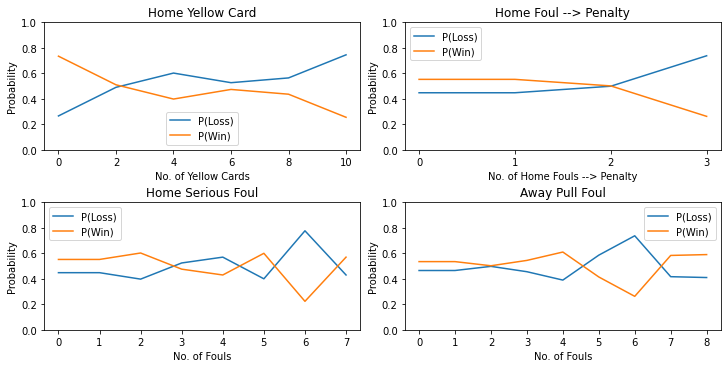

In [975]:
fig, axs = plt.subplots(2, 2, figsize = (10, 5), constrained_layout = True)
axs[0,0].plot(home_yellow)
axs[0,0].set_xticks(range(6))
axs[0,0].set_xticklabels(range(0, 12, 2))
axs[0,0].legend(labels = ['P(Loss)', 'P(Win)'])
axs[0,0].set_ylim([0,1])
axs[0,0].set_ylabel('Probability')
axs[0,0].set_xlabel('No. of Yellow Cards')

axs[0,1].plot(home_penalty)
axs[0,1].set_xticks(range(0,4))
axs[0,1].set_xticklabels(range(0, 4))
axs[0,1].legend(labels = ['P(Loss)', 'P(Win)'])
axs[0,1].set_ylim([0,1])
axs[0,1].set_ylabel('Probability')
axs[0,1].set_xlabel('No. of Home Fouls --> Penalty')

axs[1,0].plot(home_serious)
axs[1,0].legend(labels = ['P(Loss)', 'P(Win)'])
axs[1,0].set_ylim([0,1])
axs[1,0].set_ylabel('Probability')
axs[1,0].set_xlabel('No. of Fouls')

axs[1,1].plot(away_pull)
axs[1,1].legend(labels = ['P(Loss)', 'P(Win)'])
axs[1,1].set_ylim([0,1])
axs[1,1].set_ylabel('Probability')
axs[1,1].set_xlabel('No. of Fouls')

axs[0,0].set_title('Home Yellow Card')
axs[0,1].set_title('Home Foul --> Penalty')
axs[1,0].set_title('Home Serious Foul')
axs[1,1].set_title('Away Pull Foul')

plt.savefig('class_probs_byfeat.png', dpi = 200,  bbox_inches = 'tight')
plt.show()

In [980]:
data[data.columns[9:-2]]

home_team_foul_reason_from_behind  away_team_foul_reason_from_behind  \
0                                   2.0                                1.0   
1                                   0.0                                4.0   
2                                   2.0                                2.0   
3                                   0.0                                0.0   
4                                   2.0                                6.0   
...                                 ...                                ...   
2868                                2.0                                2.0   
2869                                0.0                                2.0   
2870                                0.0                                1.0   
2871                                0.0                                0.0   
2872                                0.0                                0.0   

      home_team_foul_reason_hands  away_team_foul_reason_hands  \
0                             0.0                          0.0   
1                             0.0                          2.0   
2                             0.0                          4.0   
3                             0.0                          4.0   
4                             2.0                          2.0   
...                           ...                          ...   
2868                          0.0                          0.0   
2869                          0.0                          0.0   
2870                          0.0                          0.0   
2871                          0.0                          0.0   
2872                          0.0                          1.0   

      home_team_foul_reason_pushing  away_team_foul_reason_pushing  \
0                               1.0                            1.0   
1                               2.0                            0.0   
2                               0.0                            2.0   
3                               0.0                            2.0   
4                               8.0                            2.0   
...                             ...                            ...   
2868                            2.0                            4.0   
2869                            8.0                            2.0   
2870                            1.0                            0.0   
2871                            2.0                            2.0   
2872                            3.0                            1.0   

      home_team_foul_reason_serious_foul  away_team_foul_reason_serious_foul  \
0                                    0.0                                 1.0   
1                                    2.0                                 0.0   
2                                    0.0                                 0.0   
3                                    2.0                                 4.0   
4                                    2.0                                 4.0   
...                                  ...                                 ...   
2868                                 0.0                                 2.0   
2869                                 0.0                                 0.0   
2870                                 0.0                                 0.0   
2871                                 4.0                                 0.0   
2872                                 0.0                                 0.0   

      home_team_foul_reason_shirt_pull  away_team_foul_reason_shirt_pull  ...  \
0                                  0.0                               1.0  ...   
1                                  4.0                               0.0  ...   
2                                  6.0                               0.0  ...   
3                                  2.0                               2.0  ...   
4                                  0.0                               

In [982]:
pd.get_dummies(data['result'])

D  L  W
0     0  1  0
1     0  1  0
2     0  1  0
3     0  1  0
4     0  1  0
...  .. .. ..
2868  1  0  0
2869  0  0  1
2870  0  0  1
2871  0  1  0
2872  0  0  1

[2873 rows x 3 columns]

In [999]:
inter_clf = train_test(RFinterpipe, X_drop, y, weight = True, down_sample = True, class_labels = ['W', 'L'], return_clf = True)

>>>Preprocess done {'W': 1.0, 'L': 2.061224489795918}
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.996997   0.996997  0.996997  0.996997      666
1      L  0.996997   0.996997  0.996997  0.996997      666
2  Total  0.996997   0.996997  0.996997  0.996997     1332
   Class  Accuracy  Precision    Recall        F1  Support
0      W  0.820359   0.791908  0.820359  0.805882      167
1      L  0.784431   0.813665  0.784431  0.798780      167
2  Total  0.802395   0.802786  0.802395  0.802331      334


In [1117]:
laliga_data = pd.read_csv('../data/laliga_data_elo.csv', index_col = 'Unnamed: 0')
laliga_data.head()

match_api_id  league_id                 date  home_team_api_id  \
0        530023      21518  2008-08-30 00:00:00             10267   
1        530090      21518  2008-08-30 00:00:00              8558   
2        530086      21518  2008-08-31 00:00:00              8388   
3        530085      21518  2008-08-31 00:00:00              9783   
4        530095      21518  2008-09-13 00:00:00              8634   

              home_team_name  away_team_api_id    away_team_name  \
0                Valencia CF              8661      RCD Mallorca   
1               RCD Espanyol             10281   Real Valladolid   
2                CD Numancia              8634      FC Barcelona   
3  RC Deportivo de La Coruña              8633    Real Madrid CF   
4               FC Barcelona              8696  Racing Santander   

   home_team_goal  away_team_goal  home_team_foul_reason_from_behind  ...  \
0               3               0                                1.0  ...   
1               1               0                                0.0  ...   
2               1               0                                0.0  ...   
3               2               4                                0.0  ...   
4               1               4                                0.0  ...   

   away_team_card_reason_pushing  home_team_card_reason_diving  \
0                            0.0                           0.0   
1                            0.0                           0.0   
2                            0.0                           0.0   
3                            0.0                           0.0   
4                            0.0                           0.0   

   away_team_card_reason_diving  home_team_card_reason_hands  \
0                           0.0                          0.0   
1                           0.0                          0.0   
2                           0.0                          0.0   
3                           0.0                          0.0   
4                           0.0                          2.0   

   away_team_card_reason_hands  home_team_card_reason_Removing Shirt  \
0                          0.0                                   0.0   
1                          0.0                                   0.0   
2                          0.0                                   0.0   
3                          0.0                                   0.0   
4                          2.0                                   0.0   

   away_team_card_reason_Removing Shirt  result  home_elo  away_elo  
0                                   0.0       W    1600.0    1600.0  
1                                   0.0       W    1600.0    1600.0  
2                                   0.0       W    1600.0    1600.0  
3                                   0.0       L    1600.0    1600.0  
4                                   0.0       L    1590.0    1600.0  

[5 rows x 70 columns]

In [1078]:
data['home_team_name'].iloc[X_test.index][(clf.predict(X_test) == y_test)].shape

(54,)

In [1092]:
team_1, count_correct = np.unique(data['home_team_name'].iloc[X_test.index][(clf.predict(X_test) == y_test)], return_counts = True)

In [1101]:
team_1_w, count_wrong = np.unique(data['home_team_name'].iloc[X_test.index][(clf.predict(X_test) != y_test)], return_counts = True)

In [1105]:
count_wrong[np.where(team_1_w == 'Arsenal')][0]

4

In [1119]:
np.mean(wins_sorted)

0.8203405272618829

In [1106]:
team_dict = {}
for i, t in enumerate(team_1):
    if t not in team_dict:
        team_dict[t] = [count_correct[i], appear[i]]
    if t not in team_1_w:
        team_dict[t] += [0]
    else:
        team_dict[t] += [count_wrong[np.where(team_1_w == t)][0]]
team_dict

{'Arsenal': [21, 25, 4],
 'Aston Villa': [15, 16, 1],
 'Birmingham City': [1, 2, 1],
 'Blackburn Rovers': [6, 6, 0],
 'Blackpool': [3, 3, 0],
 'Bolton Wanderers': [4, 4, 0],
 'Bournemouth': [2, 3, 1],
 'Burnley': [2, 2, 0],
 'Cardiff City': [1, 1, 0],
 'Chelsea': [18, 20, 2],
 'Crystal Palace': [5, 7, 2],
 'Everton': [15, 20, 5],
 'Fulham': [8, 9, 1],
 'Hull City': [3, 5, 2],
 'Leicester City': [5, 6, 1],
 'Liverpool': [19, 21, 2],
 'Manchester City': [9, 9, 0],
 'Manchester United': [19, 25, 6],
 'Middlesbrough': [3, 4, 1],
 'Newcastle United': [10, 12, 2],
 'Norwich City': [9, 10, 1],
 'Portsmouth': [1, 2, 1],
 'Queens Park Rangers': [3, 4, 1],
 'Reading': [1, 4, 3],
 'Southampton': [8, 9, 1],
 'Stoke City': [20, 23, 3],
 'Sunderland': [12, 13, 1],
 'Swansea City': [6, 8, 2],
 'Tottenham Hotspur': [19, 24, 5],
 'Watford': [1, 1, 0],
 'West Bromwich Albion': [9, 11, 2],
 'West Ham United': [6, 7, 1],
 'Wigan Athletic': [11, 11, 0],
 'Wolverhampton Wanderers': [5, 7, 2]}

In [1085]:
s = sorted(zip(range(len(count_correct)), count_correct, appear), key = lambda x: (x[2], x[1]/x[2]))
inds = [x[0] for x in s]
vals = [x[1]/x[2]*100 for x in s]

In [1107]:
team_sorted = sorted(list(team_dict.keys()), key = lambda x: (team_dict[x][1], team_dict[x][0]/team_dict[x][1]))
wins_sorted = [team_dict[x][0]/team_dict[x][1] for x in team_sorted]
loss_sorted = [team_dict[x][2]/team_dict[x][1] for x in team_sorted]

In [1112]:
team_sorted_p = sorted(list(team_dict.keys()), key = lambda x: (team_dict[x][0]/team_dict[x][1]))
wins_sorted_p = [team_dict[x][0]/team_dict[x][1] for x in team_sorted_p]
loss_sorted_p = [team_dict[x][2]/team_dict[x][1] for x in team_sorted_p]

In [1055]:
team_2, appear = np.unique(data['home_team_name'].iloc[X_test.index], return_counts = True)

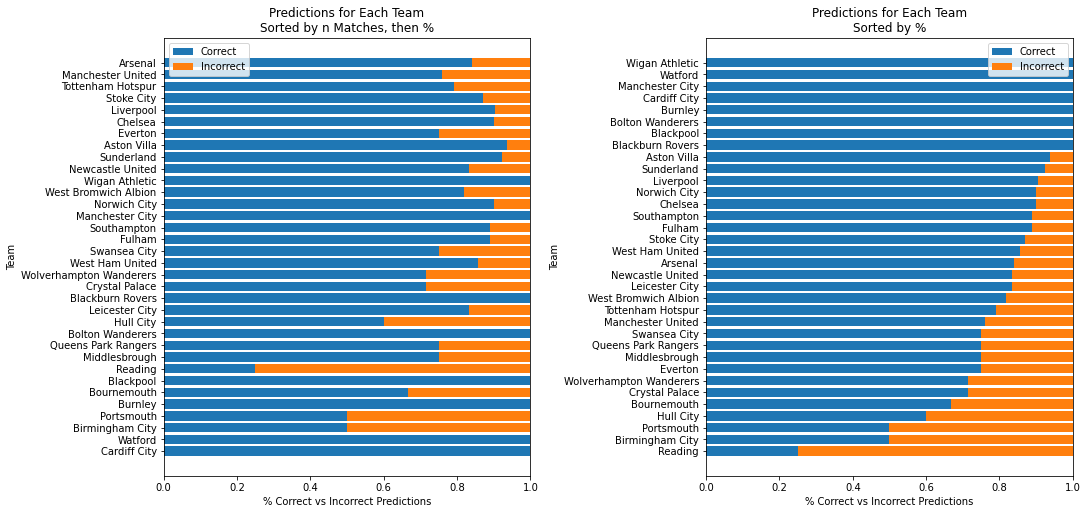

In [1116]:
fig, axs = plt.subplots(1, 2, constrained_layout = True, figsize = (15, 7))

axs[0].barh(team_sorted, wins_sorted)
axs[0].barh(team_sorted, loss_sorted, left = wins_sorted)
axs[0].set_title('Predictions for Each Team\nSorted by n Matches, then %')
axs[0].set_xlabel('% Correct vs Incorrect Predictions')
axs[0].set_ylabel('Team')
axs[0].legend(labels = ['Correct', 'Incorrect'])

axs[1].set_title('Predictions for Each Team\nSorted by %')
axs[1].barh(team_sorted_p, wins_sorted_p)
axs[1].barh(team_sorted_p, loss_sorted_p, left = wins_sorted_p)
axs[1].set_xlabel('% Correct vs Incorrect Predictions')
axs[1].set_ylabel('Team')
axs[1].legend(labels = ['Correct', 'Incorrect'])

#plt.savefig('correct_matches.png', dpi = 200)
plt.show()

In [1025]:
data[['home_team_name','away_team_name']].iloc[X_test.index][(clf.predict(X_test) == y_test)]

home_team_name           away_team_name
509             Stoke City           Wigan Athletic
1072                Fulham                  Arsenal
1740            Sunderland                  Everton
259              Liverpool               Sunderland
1423        Wigan Athletic  Wolverhampton Wanderers
...                    ...                      ...
2427               Chelsea              Southampton
1292  West Bromwich Albion             Swansea City
1308               Chelsea         Bolton Wanderers
2775            Sunderland           Crystal Palace
324   West Bromwich Albion               Sunderland

[280 rows x 2 columns]

In [1014]:
inter_columns = inter_clf['inter'].get_feature_names_out(X_drop.columns)

In [1015]:
r = permutation_importance(inter_clf['rf'], inter_clf['inter'].transform(X_test[X_drop.columns]), y_test, n_repeats = 30)

qual_idx = []
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2* r.importances_std[i] > 0:
        qual_idx += [i]
        print("{feat}\t\t{mean} +/- {std}".format(
            feat = inter_columns[i],
            mean = np.round(r.importances_mean[i], 3),
            std = np.round(r.importances_std[i], 3)
        ))

away_team_card_color_y away_team_card_reason_emergency_brake		0.011 +/- 0.004
away_team_card_color_r		0.01 +/- 0.004
home_team_foul_reason_from_behind away_team_card_reason_Unsportsmanlike Cond		0.009 +/- 0.002
home_team_card_color_y away_team_card_reason_violence		0.007 +/- 0.003
home_team_foul_reason_diving home_team_card_color_y		0.007 +/- 0.002
home_team_foul_reason_serious_foul away_team_card_color_r		0.006 +/- 0.003
home_team_foul_reason_pushing away_team_card_color_r		0.006 +/- 0.002
home_team_foul_reason_from_behind away_team_card_reason_emergency_brake		0.006 +/- 0.002
home_team_foul_reason_from_behind away_team_card_color_r		0.006 +/- 0.001
home_team_foul_reason_dangerous_play away_team_card_reason_emergency_brake		0.006 +/- 0.001
home_team_card_color_y away_team_card_color_r		0.005 +/- 0.002
home_team_foul_reason_trip away_team_card_color_y		0.004 +/- 0.002
home_team_card_color_y home_team_card_reason_stall_time		0.003 +/- 0.002
home_team_foul_reason_trip home_team_card_reas

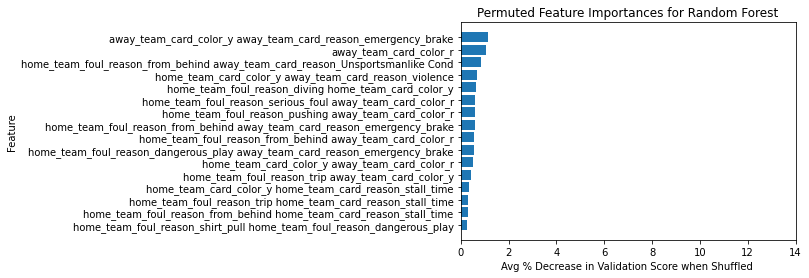

In [1016]:
plt.barh(inter_columns[qual_idx][::-1], r.importances_mean[qual_idx][::-1]*100)
plt.title('Permuted Feature Importances for Random Forest')
plt.xlabel('Avg % Decrease in Validation Score when Shuffled ')
plt.ylabel('Feature')
plt.xticks(range(0, 16, 2))
#plt.savefig('feat_imp_rf.png', dpi = 200, bbox_inches='tight')
plt.show()

In [1007]:
#qual_idx = []
for i in r.importances_mean.argsort()[::-1]:
    #if r.importances_mean[i] - 2* r.importances_std[i] > 0:
    #qual_idx += [i]
    print("{feat}\t\t{mean} +/- {std}".format(
        feat = X_drop.columns[i],
        mean = np.round(r.importances_mean[i], 3),
        std = np.round(r.importances_std[i], 3)
    ))

home_team_card_color_y		0.128 +/- 0.018
home_team_foul_reason_serious_foul		0.032 +/- 0.012
home_team_foul_reason_penalty		0.025 +/- 0.008
away_team_card_color_y		0.018 +/- 0.01
home_team_foul_reason_dangerous_play		0.014 +/- 0.008
away_team_foul_reason_hands		0.012 +/- 0.01
away_team_card_color_r		0.009 +/- 0.009
away_team_card_reason_emergency_brake		0.009 +/- 0.004
home_team_foul_reason_pushing		0.008 +/- 0.01
home_team_foul_reason_pull		0.008 +/- 0.005
home_team_card_color_r		0.008 +/- 0.004
home_team_foul_reason_advantage		0.007 +/- 0.004
away_team_foul_reason_dangerous_play		0.006 +/- 0.006
home_team_foul_reason_diving		0.006 +/- 0.002
home_team_card_reason_verbal_abuse		0.005 +/- 0.003
home_team_foul_reason_hands		0.005 +/- 0.01
home_team_foul_reason_shirt_pull		0.005 +/- 0.005
away_team_foul_reason_obstruction		0.004 +/- 0.008
away_team_foul_reason_serious_foul		0.004 +/- 0.01
home_team_card_reason_stall_time		0.004 +/- 0.003
home_team_foul_reason_obstruction		0.003 +/- 0.004
a

In [1008]:
r.importances_mean.shape

(49,)